# King County House Price Analysis 

In [3]:
# import packages
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sms
import statsmodels.formula.api as smf
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from ipyleaflet import Map, basemaps, basemap_to_tiles, CircleMarker, LayerGroup

## First Data Exploration

In [4]:
# read data
house_sales_df = pd.read_csv("King_County_House_prices_dataset.csv")
# column names
print("column names:")
print(house_sales_df.columns)
# number of observations and columns
print("number of observations and columns:")
print(house_sales_df.shape)
house_sales_df.head()

FileNotFoundError: [Errno 2] File b'King_County_House_prices_dataset.csv' does not exist: b'King_County_House_prices_dataset.csv'

In [ ]:
house_sales_df.tail()

In [ ]:
# What data type are the entries and are there missing values?
house_sales_df.info()

### Analyse the "price" variable (prediction variable)

In [ ]:
print("Unique price values:")
print(house_sales_df["price"].unique())
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].hist(house_sales_df["price"]/1000000) #prices in million $
ax[0].set_title("All House Prices (in M)")
ax[1].hist(house_sales_df["price"]/1000000)
ax[1].set_title("House Prices above 4M (in M)")
plt.xlim(3,8)
plt.ylim(0,50)
plt.savefig('price_hist.jpg', dpi=300)

Observations:

* Most price lie between 0 and 4.000.0000
* Only few very high price

# General Data Cleaning

In [ ]:
house_sales_df_cp = house_sales_df # generate a copy of the dataframe

### Delete very expensive houses (>4M)

In [ ]:
idx = house_sales_df.index[house_sales_df_cp["price"] > 4000000]
house_sales_df_cp.drop(index=idx,inplace=True)
fig, ax = plt.subplots(figsize=(4,4))
ax.hist(house_sales_df_cp["price"]/1000000)
ax.set_title("All House Prices (in M)");
plt.savefig('price_hist_lower4M.jpg', dpi=300)

In [ ]:
house_sales_df.info()

### Missing Values

The following columns contain missing values:

* waterfront 21586 - 19210 = 2376 missing values (= 11% of the observations)
* view 21586 - 21524 = 62 missing values (0.3% of the observations)
* yr_renovated 21586 - 17745 = 3841 missing values (17.8% of the observations)

Have a closer look at these features. Which values do they take?

In [ ]:
print("waterfront values")
print(house_sales_df["waterfront"].unique())
print("view values")
print(house_sales_df["view"].unique())
print("yr_renovated values")
print(house_sales_df["yr_renovated"].unique())

How do we treat the missing values?
* Waterfront - House which has a view to a waterfront: Variable takes two possible values (0: no waterfront view, 1 waterfrot view), we can assume that a missing value in this variable means the house has no view to the waterfront, that is nan-values are set to 0
* view - How is the view, only few missing values, delete observation with missing values
* yr_renovated - Year when house was renovated: contains either the year in which it was renovated or 0, we can assume that nan means, that the house has not been renovated, that is nan can be replaced by 0

In [ ]:
house_sales_df_cp["waterfront"].fillna(0,inplace=True)
house_sales_df_cp["yr_renovated"].fillna(0,inplace=True)
house_sales_df_cp.dropna(0,inplace=True)
house_sales_df_cp.info()

### Drop variables that are not interesting for the price prediction:
* id - unique identified for a house
* date - house was sold

In [ ]:
house_sales_df_cp.drop(["id","date"],axis=1, inplace=True)

### Explore the remaining variables:

In [ ]:
house_sales_df_cp.columns

In [ ]:
## bedrooms and bathrooms
print("bedrooms unique")
print(house_sales_df_cp["bedrooms"].unique())
print("bathrooms unique")
print(house_sales_df_cp["bathrooms"].unique())

Observations: 

* The variable bedrooms seems to have an outlier -> value 33
* Make a scatter plot between price and bedrooms and a boxplot of bedrooms

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].scatter(house_sales_df_cp["price"]/1000000,house_sales_df_cp["bedrooms"])
ax[0].set_xlabel("House prices")
ax[0].set_ylabel("Bedrooms")
ax[1].boxplot(house_sales_df_cp["bedrooms"],patch_artist=True)
ax[1].set_xlabel("Bedrooms");

Observations:

* The assumption of the outlier is confirmed. Delete the observation with 33 bedrooms

In [ ]:
idx = house_sales_df_cp.index[house_sales_df_cp["bedrooms"] == 33]
house_sales_df_cp.drop(index=idx,inplace=True)

fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].scatter(house_sales_df_cp["price"]/1000000,house_sales_df_cp["bedrooms"])
ax[0].set_xlabel("House prices")
ax[0].set_ylabel("Bedrooms")
ax[1].boxplot(house_sales_df_cp["bedrooms"],patch_artist=True)
ax[1].set_xlabel("Bedrooms");

In [ ]:
# area measures
print("sqft_lot unique")
print(house_sales_df_cp["sqft_lot"].unique())
print("sqft_living")
print(house_sales_df_cp["sqft_living"].unique())
print("sqft_above unique")
print(house_sales_df_cp["sqft_above"].unique())
print("sqft_basement unique")
print(house_sales_df_cp["sqft_basement"].unique())
print("sqft_living15 unique")
print(house_sales_df_cp["sqft_living15"].unique())
print("sqft_lot15 unique")
print(house_sales_df_cp["sqft_lot15"].unique())

Observations:

* sqft_basement has entry "?" for at least one observation
* sqft_basement contains strings
* Dependency: sqft_living = sqft_above + sqft_basement

-> drop sqft_basement (because of dependency)

In [ ]:
house_sales_df_cp.drop(["sqft_basement"],axis=1, inplace=True)
house_sales_df_cp.columns

In [ ]:
# location
print("zipcode unique")
print(house_sales_df_cp["zipcode"].unique())
print("lat unique")
print(house_sales_df_cp["lat"].unique())
print("long unique")
print(house_sales_df_cp["long"].unique())

In [ ]:
# Plot Price depending on locations 
# radius is proportional to price rounded to Millions
df_lonlat = house_sales_df_cp[["long","lat","price"]]
m = Map(center = (47.5, -122.3), zoom = 10, basemaps = basemaps.OpenStreetMap.DE)
def create_marker(df_lonlat):
   lat_lon = (df_lonlat["lat"], df_lonlat["long"])
   size = int(round(df_lonlat['price']/1000000)) 
   return CircleMarker(location=lat_lon, draggable=False, radius=size, fill_opacity=0.5,stroke=False,scroll_wheel_zoom=True)

markers = df_lonlat.apply(create_marker, axis=1)
layer_group = LayerGroup(layers=tuple(markers.values))
m.add_layer(layer_group)
m

In [ ]:
# remaining variables
print("view unique")
print(house_sales_df_cp["view"].unique())
print("floors unique")
print(house_sales_df_cp["floors"].unique())
print("waterfront unique")
print(house_sales_df_cp["waterfront"].unique())
print("condition unique")
print(house_sales_df_cp["condition"].unique())
print("grade unique")
print(house_sales_df_cp["grade"].unique())
print("yr_built unique")
print(house_sales_df_cp["yr_built"].unique())
print("yr_renovated unique")
print(house_sales_df_cp["yr_renovated"].unique())


Have a closer look at waterfront

In [ ]:
print(house_sales_df_cp[house_sales_df_cp["waterfront"]==1]['price'].count())
print(house_sales_df_cp[house_sales_df_cp["waterfront"]==0]['price'].count())
print(141/21382)

Observations:

* Only very few houses are at the waterfront compared to entire dataset

### drop some variables, that are not interesting for us: 

* lat, long (go together with zipcode)
* condition (does not seem to cary information), a value for grading the house is given in "grade"
* waterfront (only very few houses have this variable set to 1) 

In [ ]:
house_sales_df_cp.drop(["lat","long","condition","waterfront"],axis=1, inplace=True)

# Business Case

### Goal: Predict House Prices

* King county is a bg area, which is not homogenous: Seattle (big city) vs. mountains
* Can we use the same model for predicting house prices in King County or do we need to adopt the model depending on the region?

### King County can be divided in 4 regions: North, South, East and Seattle 

* based on (https://www.kingcounty.gov/depts/health/data/community-health-indicators/definitions.aspx)
* North Region: Bothell, Cottage Lake, Kenmore, Lake Forest Park, Shoreline, Woodinville, Fall City
* East Region: Bellevue, Carnation, Duvall, Issaquah, Kirkland, Medina, Mercer Island, Newcastle, North Bend, Redmond, Sammamish, Skykomish, Snoqualmie 
* South region: Auburn, Burien, Covington, Des Moines, Enumclaw, Federal Way, Kent, Maple Valley, Normandy Park, Renton, Tukwila, SeaTac, White Center/Boulevard Park, Vashon Island, Black Diamond

### Question: Is the model needed for the prediction depending on the region?

* Do we need different features for the model?
* Do we need to adapt the coefficients for each region?


### Create 4 regions, depending on the zipcode

* region of the zipcode is based on https://www.zipmap.net/Washington/King_County.htm





In [ ]:
# create regions depending on zipcodes
North = [98028, 98077, 98024, 98011, 98072]
Seattle = [98178, 98125, 98136, 98198, 98146, 98115, 98107, 98126, 98103, 98133, 98119, 98112, 98117, 98166, 98148, 98105, 98122, 98144, 98116, 98118, 98199, 98102, 98108, 98168, 98177, 98109, 98155, 98106, 98188]
East = [98074, 98053, 98007, 98019, 98040, 98052, 98027, 98008, 98004, 98005, 98034, 98075, 98045, 98065, 98029, 98006, 98006, 98033, 98014, 98039]
South = [98003, 98038, 98002, 98092, 98030, 98058, 98001, 98056, 98023, 98070, 98042, 98059, 98010, 98032, 98022, 98031, 98055]

### Create 4 sub dataframes depending on the regions

In [ ]:
north_df = house_sales_df_cp[house_sales_df_cp['zipcode'].isin(North)]
seattle_df = house_sales_df_cp[house_sales_df_cp['zipcode'].isin(Seattle)]
east_df = house_sales_df_cp[house_sales_df_cp['zipcode'].isin(East)]
south_df = house_sales_df_cp[house_sales_df_cp['zipcode'].isin(South)]

In [ ]:
# Distribution of the house prices depending on the region
fig, ax = plt.subplots(1,4, figsize=(17,4))
ax[0].hist(north_df["price"]/1000000)
ax[0].set_title("Region North")
ax[0].set_xlim(0,3)
ax[0].set_ylabel("Price in M")
ax[1].hist(south_df["price"]/1000000)
ax[1].set_title("Region South")
ax[1].set_xlim(0,3)
ax[2].hist(east_df["price"]/1000000)
ax[2].set_title("Region East")
ax[2].set_xlim(0,3)
ax[3].hist(seattle_df["price"]/1000000)
ax[3].set_title("Region Seattle")
ax[3].set_xlim(0,3)
#plt.ylim(0,50)
plt.savefig('price_hist_regions.jpg', dpi=300)

### Create Heatmaps of correlations for each of the 4 regions and the entire dataset 

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
#mask = np.triu(df_high_corr.corr())
ax = sns.heatmap(round(house_sales_df_cp.corr(),2)
                 ,annot=True
                 #,mask=mask
                 ,cmap='coolwarm'
                 ,vmin=-1)
ax.set_ylim((0,14))
plt.savefig('heat_corr_house_sales_tot.jpg', dpi=300)
house_sales_df_cp.shape

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
#mask = np.triu(df_high_corr.corr())
ax = sns.heatmap(round(north_df.corr(),2)
                 ,annot=True
                 #,mask=mask
                 ,cmap='coolwarm'
                 ,vmin=-1)
ax.set_ylim((0,14))
north_df.shape

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
#mask = np.triu(df_high_corr.corr())
ax = sns.heatmap(round(south_df.corr(),2)
                 ,annot=True
                 #,mask=mask
                 ,cmap='coolwarm'
                 ,vmin=-1)
ax.set_ylim((0,14))
south_df.shape

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
#mask = np.triu(df_high_corr.corr())
ax = sns.heatmap(round(east_df.corr(),2)
                 ,annot=True
                 #,mask=mask
                 ,cmap='coolwarm'
                 ,vmin=-1)
ax.set_ylim((0,14))
east_df.shape

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
#mask = np.triu(df_high_corr.corr())
ax = sns.heatmap(round(seattle_df.corr(),2)
                 ,annot=True
                 #,mask=mask
                 ,cmap='coolwarm'
                 ,vmin=-1)
ax.set_ylim((0,14))
seattle_df.shape

Observations:
    
* Number of observations in each sub-dataframe differ: 
  * Total: 21585
  * North: 1029
  * South: 5527
  * East: 6059
  * Seattle: 8970
* Features with highest correlations with Price (>0.5):
  * Total: bathrooms (0.52), sqft_living (0.69), grade (0.68), sqft_above (0.6), sqft_living15 (0.6)
  * North: bathrooms (0.68), sqft_living (0.84), grade (0.8), sqft_above (0.83), sqft_living15 (0.74)
  * South: bathrooms (0.54), sqft_living (0.74), grade (0.68), sqft_above (0.69), sqft_living15 (0.67)
  * East: bathrooms (0.58), sqft_living (0.73), grade (0.68), sqft_above (0.63), sqft_living15 (0.61) 
  * Seattle: bathrooms (0.51), sqft_living (0.71), grade (0.7), sqft_above (0.66), sqft_living15 (0.64)
* Colinearity (within the above features):
  * sqft_living and sqft_above have high correlation, cannot be considered as linear independend
  * In general these features are also correlated with each other and have to be considered carefully in a linear regression
* The features with highes correlations with the price are the same for each region, but correlations differ, especially for the region North
* __NOTE__: Be careful with categorical variables! The variables with correlaion >0.5 are all numerical, except grade. The feature grade will be considered seperately later  

Have a closer look at the (numerical) features with high (>0.5) correlations

In [ ]:
df_high_corr_tot = house_sales_df_cp[["price","bathrooms","sqft_living","sqft_above","sqft_living15"]]
df_high_corr_north = north_df[["price","bathrooms","sqft_living","sqft_above","sqft_living15"]]
df_high_corr_south = south_df[["price","bathrooms","sqft_living","sqft_above","sqft_living15"]]
df_high_corr_east = east_df[["price","bathrooms","sqft_living","sqft_above","sqft_living15"]]
df_high_corr_seattle = seattle_df[["price","bathrooms","sqft_living","sqft_above","sqft_living15"]]

fig, ax = plt.subplots(figsize=(4,4))
#mask = np.triu(df_high_corr.corr())
sns.heatmap(round(df_high_corr_tot.corr(),2)
                 ,annot=True
                 #,mask=mask
                 ,cmap='coolwarm'
                 ,vmin=-1)
ax.set_ylim((0,5))
ax.set_title("Complete Dataset")
plt.savefig('heat_corr_house_sales_tot_highcorr.jpg', dpi=300)

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(round(df_high_corr_north.corr(),2)
                 ,annot=True
                 #,mask=mask
                 ,cmap='coolwarm'
                 ,vmin=-1)
ax.set_ylim((0,4))
ax.set_title("Region North")

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(round(df_high_corr_south.corr(),2)
                 ,annot=True
                 #,mask=mask
                 ,cmap='coolwarm'
                 ,vmin=-1)
ax.set_ylim((0,5))
ax.set_title("Region South")

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(round(df_high_corr_east.corr(),2)
                 ,annot=True
                 #,mask=mask
                 ,cmap='coolwarm'
                 ,vmin=-1)
ax.set_ylim((0,5))
ax.set_title("Region East")

fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(round(df_high_corr_seattle.corr(),2)
                 ,annot=True
                 #,mask=mask
                 ,cmap='coolwarm'
                 ,vmin=-1)
ax.set_ylim((0,5))
ax.set_title("Seattle");

Observation:
* As noted above all these features are correlated among each other 

# A first simple model

As a first step towards price prediction perform a simple linear regression with the feature that shows highest correltation (sqft_living)

### Create train and test sets for the complete dataset (all regions together)

In [ ]:
# create training and testing vars
X_tot = house_sales_df_cp[["sqft_living"]]
y_tot = house_sales_df_cp["price"]/1000000
X_tot_train, X_tot_test, y_tot_train, y_tot_test = train_test_split(X_tot, y_tot, test_size=0.2)
print("Train set length (x,y)")
print(X_tot_train.shape, y_tot_train.shape)
print("Test set length (x,y)")
print(X_tot_test.shape, y_tot_test.shape)

### Fit the model for the complete dataset 

In [ ]:
# fit a model
lm = linear_model.LinearRegression()
model_tot = lm.fit(X_tot_train, y_tot_train)
predictions_tot = lm.predict(X_tot_test)

### Plot model results vs. real values for the complete dataset

In [ ]:
## The line / model
fig, ax = plt.subplots(figsize=(4,4))
plt.scatter(y_tot_test, predictions_tot, alpha=0.3)
x = np.linspace(0,4,100)
y = np.linspace(0,4,100)
ax.plot(x,y)
ax.set_title("House price prediction (in M)")
plt.xlabel("True Values")
plt.ylabel("Predictions");

Observations: 

* A general underestimation can be seen
* Use a logarithmic transformation for target and features
* Repeat the above model with logarthmic transformation

In [ ]:
# linear regression with logarithmic transformation
# model with only one independend variable, with highest correlation
X = house_sales_df_cp[["sqft_living"]]
y = house_sales_df_cp["price"]/1000000
ln_y = np.log(y)
ln_X = np.log(X)
X_tot_ln_train, X_tot_ln_test, y_tot_ln_train, y_tot_ln_test = train_test_split(ln_X, ln_y, test_size=0.2)
print("Train set length (x,y)")
print(X_tot_ln_train.shape, y_tot_ln_train.shape)
print("Test set length (x,y)")
print(X_tot_ln_test.shape, y_tot_ln_test.shape)
# fit a model
lm = linear_model.LinearRegression()
model_tot_ln = lm.fit(X_tot_ln_train, y_tot_ln_train)
predictions_tot_ln = lm.predict(X_tot_ln_test)
## The line / model
fig, ax = plt.subplots(figsize=(4,4))
plt.scatter(y_tot_ln_test, predictions_tot_ln, alpha=0.3)
x = np.linspace(0,2,100)
y = np.linspace(0,2,100)
ax.plot(x,y)
plt.xlabel("True Values")
plt.ylabel("Predictions");

### Consider the residuals

* Compare the residuals of the two linear regressions above (with and without logarithmic transformation)

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(12,4))
residuals_tot = y_tot_test - predictions_tot
residuals_tot_ln = y_tot_ln_test - predictions_tot_ln
x = np.linspace(0,100000,4305)
plt.subplot(131)
plt.plot(x,residuals_tot)
plt.ylim(-2.5,2.5)
plt.title("linear regression")
plt.subplot(132)
plt.plot(x,residuals_tot_ln)
plt.title("linear regression w logarithmic transformation")
plt.ylim(-2.5,2.5);

Observations: 

* The fit is better using logarithmic transformation, bias is reduced
* The residuals look more like white noise

-> Keep the logarithmic transformation

### Perform this regression for the 4 regions

In [ ]:
# Train/ Test sets
X_north = north_df[["sqft_living"]]
y_north = north_df["price"]/1000000
ln_y_north = np.log(y_north)
ln_X_north = np.log(X_north)
X_north_ln_train, X_north_ln_test, y_north_ln_train, y_north_ln_test = train_test_split(ln_X_north, ln_y_north, test_size=0.2)
print("Train set length North (x,y)")
print(X_north_ln_train.shape, y_north_ln_train.shape)
print("Test set length North (x,y)")
print(X_north_ln_test.shape, y_north_ln_test.shape)

X_south = south_df[["sqft_living"]]
y_south = south_df["price"]/1000000
ln_y_south = np.log(y_south)
ln_X_south = np.log(X_south)
X_south_ln_train, X_south_ln_test, y_south_ln_train, y_south_ln_test = train_test_split(ln_X_south, ln_y_south, test_size=0.2)
print("Train set length South (x,y)")
print(X_south_ln_train.shape, y_south_ln_train.shape)
print("Test set length South (x,y)")
print(X_south_ln_test.shape, y_south_ln_test.shape)

X_east = east_df[["sqft_living"]]
y_east = east_df["price"]/1000000
ln_y_east = np.log(y_east)
ln_X_east = np.log(X_east)
X_east_ln_train, X_east_ln_test, y_east_ln_train, y_east_ln_test = train_test_split(ln_X_east, ln_y_east, test_size=0.2)
print("Train set length East (x,y)")
print(X_east_ln_train.shape, y_east_ln_train.shape)
print("Test set length East (x,y)")
print(X_east_ln_test.shape, y_east_ln_test.shape)

X_seattle = seattle_df[["sqft_living"]]
y_seattle = seattle_df["price"]/1000000
ln_y_seattle = np.log(y_seattle)
ln_X_seattle = np.log(X_seattle)
X_seattle_ln_train, X_seattle_ln_test, y_seattle_ln_train, y_seattle_ln_test = train_test_split(ln_X_seattle, ln_y_seattle, test_size=0.2)
print("Train set length Seattle (x,y)")
print(X_seattle_ln_train.shape, y_seattle_ln_train.shape)
print("Test set length Seattle (x,y)")
print(X_seattle_ln_test.shape, y_seattle_ln_test.shape)


# fit a model
lm = linear_model.LinearRegression()
model_north_ln = lm.fit(X_north_ln_train, y_north_ln_train)
predictions_north_ln = lm.predict(X_north_ln_test)

lm = linear_model.LinearRegression()
model_south_ln = lm.fit(X_south_ln_train, y_south_ln_train)
predictions_south_ln = lm.predict(X_south_ln_test)

lm = linear_model.LinearRegression()
model_east_ln = lm.fit(X_east_ln_train, y_east_ln_train)
predictions_east_ln = lm.predict(X_east_ln_test)

lm = linear_model.LinearRegression()
model_seattle_ln = lm.fit(X_seattle_ln_train, y_seattle_ln_train)
predictions_seattle_ln = lm.predict(X_seattle_ln_test)




In [2]:
## The line / model + residuals
residuals_north_ln = y_north_ln_test - predictions_north_ln
residuals_south_ln = y_south_ln_test - predictions_south_ln
residuals_east_ln = y_east_ln_test - predictions_east_ln
residuals_seattle_ln = y_seattle_ln_test - predictions_seattle_ln

fig, ax = plt.subplots(5, 2,figsize=(12,16))
fig.tight_layout(pad=3.0)
ax[0,0].scatter(y_tot_ln_test, predictions_tot_ln, alpha=0.3)
x = np.linspace(-2,2,100)
y = np.linspace(-2,2,100)
ax[0,0].plot(x,y)
ax[0,0].set_title("Complete Dataset")
ax[0,0].set_xlabel("True Values")
ax[0,0].set_ylabel("Predictions")
ax[0,0].set_xlim(-2.5,2.5)
x1 = np.linspace(-2,2,4305)
ax[0,1].plot(x1,residuals_tot_ln)
ax[0,1].set_ylim(-1.5,1.5)
ax[0,1].set_title("Residuals")

ax[1,0].scatter(y_north_ln_test, predictions_north_ln, alpha=0.3)
x = np.linspace(-2,2,100)
y = np.linspace(-2,2,100)
ax[1,0].plot(x,y)
ax[1,0].set_title("Region North")
ax[1,0].set_xlabel("True Values")
ax[1,0].set_ylabel("Predictions")
ax[1,0].set_xlim(-2.5,2.5)
x1 = np.linspace(-2,2,205)
ax[1,1].plot(x1,residuals_north_ln)
ax[1,1].set_ylim(-1.5,1.5)
ax[1,1].set_title("Residuals")

ax[2,0].scatter(y_south_ln_test, predictions_south_ln, alpha=0.3)
x = np.linspace(-2,2,100)
y = np.linspace(-2,2,100)
ax[2,0].plot(x,y)
ax[2,0].set_title("Region South")
ax[2,0].set_xlabel("True Values")
ax[2,0].set_ylabel("Predictions")
ax[2,0].set_xlim(-2.5,2.5)
x1 = np.linspace(-2,2,1102)
ax[2,1].plot(x1,residuals_south_ln)
ax[2,1].set_ylim(-1.5,1.5)
ax[2,1].set_title("Residuals")

ax[3,0].scatter(y_east_ln_test, predictions_east_ln, alpha=0.3)
x = np.linspace(-2,2,100)
y = np.linspace(-2,2,100)
ax[3,0].plot(x,y)
ax[3,0].set_title("Region East")
ax[3,0].set_xlabel("True Values")
ax[3,0].set_ylabel("Predictions")
ax[3,0].set_xlim(-2.5,2.5)
x1 = np.linspace(-2,2,1210)
ax[3,1].plot(x1,residuals_east_ln)
ax[3,1].set_ylim(-1.5,1.5)
ax[3,1].set_title("Residuals")

ax[4,0].scatter(y_seattle_ln_test, predictions_seattle_ln, alpha=0.3)
x = np.linspace(-2,2,100)
y = np.linspace(-2,2,100)
ax[4,0].plot(x,y)
ax[4,0].set_title("Seattle")
ax[4,0].set_xlabel("True Values")
ax[4,0].set_ylabel("Predictions")
ax[4,0].set_xlim(-2.5,2.5)
x1 = np.linspace(-2,2,1789)
ax[4,1].plot(x1,residuals_seattle_ln)
ax[4,1].set_ylim(-1.5,1.5)
plt.savefig('simple_linear_regression_eval.jpg', dpi=300)
ax[4,1].set_title("Residuals")

NameError: name 'y_north_ln_test' is not defined

* Look at the p-values for the test case

In [169]:
print("p-values for complete dataset:")
mod = sms.OLS(y_tot_ln_test,X_tot_ln_test)
fii = mod.fit()
p_values = fii.summary2().tables[1]['P>|t|']
print(p_values);

print("p-values for North:")
mod = sms.OLS(y_north_ln_test,X_north_ln_test)
fii = mod.fit()
p_values = fii.summary2().tables[1]['P>|t|']
print(p_values)

print("p-values for South:")
mod = sms.OLS(y_south_ln_test,X_south_ln_test)
fii = mod.fit()
p_values = fii.summary2().tables[1]['P>|t|']
print(p_values)

print("p-values for East:")
mod = sms.OLS(y_east_ln_test,X_east_ln_test)
fii = mod.fit()
p_values = fii.summary2().tables[1]['P>|t|']
print(p_values)

print("p-values for Seattle:")
mod = sms.OLS(y_seattle_ln_test,X_seattle_ln_test)
fii = mod.fit()
p_values = fii.summary2().tables[1]['P>|t|']
print(p_values);

p-values for complete dataset:
sqft_living    0.0
Name: P>|t|, dtype: float64
p-values for North:
sqft_living    9.723164e-56
Name: P>|t|, dtype: float64
p-values for South:
sqft_living    0.0
Name: P>|t|, dtype: float64
p-values for East:
sqft_living    7.508612e-147
Name: P>|t|, dtype: float64
p-values for Seattle:
sqft_living    0.0
Name: P>|t|, dtype: float64


Observations:
* All p-values are smaller than 0.05, that is the coefficients are statistically significant at al 95% level   

### How do the models perform?

* Look at R²

In [303]:
print("R^2 Total Dataset")
print("{:.2}".format(r2_score(y_tot_ln_test, predictions_tot_ln, sample_weight=None, multioutput='uniform_average')))
print("R^2 North")
print("{:.2}".format(r2_score(y_north_ln_test, predictions_north_ln, sample_weight=None, multioutput='uniform_average')))
print("R^2 South")
print("{:.2}".format(r2_score(y_south_ln_test, predictions_south_ln, sample_weight=None, multioutput='uniform_average')))
print("R^2 East")
print("{:.2}".format(r2_score(y_east_ln_test, predictions_east_ln, sample_weight=None, multioutput='uniform_average')))
print("R^2 Seattle")
print("{:.2}".format(r2_score(y_seattle_ln_test, predictions_seattle_ln, sample_weight=None, multioutput='uniform_average')))

R^2 Total Dataset
0.42
R^2 North
0.73
R^2 South
0.57
R^2 East
0.61
R^2 Seattle
0.43


* Look at the mean squared error

In [304]:
# mean squared error
print("MSE Total Dataset")
print("{:.2}".format(mean_squared_error(y_tot_ln_test, predictions_tot_ln)))
print("MSE North")
print("{:.2}".format(mean_squared_error(y_north_ln_test, predictions_north_ln)))
print("MSE South")
print("{:.2}".format(mean_squared_error(y_south_ln_test, predictions_south_ln)))
print("MSE East")
print("{:.2}".format(mean_squared_error(y_east_ln_test, predictions_east_ln)))
print("MSE Seattle")
print("{:.2}".format(mean_squared_error(y_seattle_ln_test, predictions_seattle_ln)))

MSE Total Dataset
0.15
MSE North
0.037
MSE South
0.058
MSE East
0.087
MSE Seattle
0.14


Observations:
    
* R² is higher for the single regions than for the total dataset
* R² has highest value for the region North and lowest for the region Seattle
* The mean squared error is analogue to R², lowest for the Region North, highest for Seattle
* Maybe for Seattle we have to look at different/more features

### How do the coefficients look like for each model?

In [305]:
print("Complete Dataset")
print("coefficient: {:.2}".format(model_tot_ln.coef_[0]))
print("intercept: {:.2}".format(model_tot_ln.intercept_))
print("North")
print("coefficient: {:.2}".format(model_north_ln.coef_[0]))
print("intercept: {:.2}".format(model_north_ln.intercept_))
print("South")
print("coefficient: {:.2}".format(model_south_ln.coef_[0]))
print("intercept: {:.2}".format(model_south_ln.intercept_))
print("East")
print("coefficient: {:.2}".format(model_east_ln.coef_[0]))
print("intercept: {:.2}".format(model_east_ln.intercept_))
print("Seattle")
print("coefficient: {:.2}".format(model_seattle_ln.coef_[0]))
print("intercept: {:.2}".format(model_seattle_ln.intercept_))

Complete Dataset
coefficient: 0.84
intercept: -7.1
North
coefficient: 0.78
intercept: -6.7
South
coefficient: 0.76
intercept: -6.8
East
coefficient: 0.89
intercept: -7.4
Seattle
coefficient: 0.81
intercept: -6.7


# Can the model be improved?

* Problem: most of the features that have high correlation with the price, also have high correlations with sqrt_living
* Test if the model improves its performans, when the variable grade is included
* grade has to be traded as a categorical variable

In [306]:
# which values does grade take
print(house_sales_df_cp["grade"].unique())
print(north_df["grade"].unique())
print(south_df["grade"].unique())
print(east_df["grade"].unique())
print(seattle_df["grade"].unique())

[ 7  6  8 11  9  5 10 12  4  3 13]
[ 6  7  8 10  9 11 12  5  4]
[ 7  8  6  9 10  5 11  4 12  3 13]
[ 8 11  7  9  5 10 12  6  4 13]
[ 7  9  8  6 10  5 12 11 13  4]


In [307]:
# set grade as categorical variable
grade_cat_tot = house_sales_df_cp["grade"].astype('category')
grade_dum_tot = pd.get_dummies(grade_cat_tot, drop_first=True)
grade_cat_north = north_df["grade"].astype('category')
grade_dum_north = pd.get_dummies(grade_cat_north, drop_first=True)
grade_cat_south = south_df["grade"].astype('category')
grade_dum_south = pd.get_dummies(grade_cat_south, drop_first=True)
grade_cat_east = east_df["grade"].astype('category')
grade_dum_east = pd.get_dummies(grade_cat_east, drop_first=True)
grade_cat_seattle = seattle_df["grade"].astype('category')
grade_dum_seattle = pd.get_dummies(grade_cat_seattle, drop_first=True)
# merge with dataframe
total_grade = pd.concat([house_sales_df_cp, grade_dum_tot], axis=1)
north_grade = pd.concat([north_df, grade_dum_north], axis=1)
south_grade = pd.concat([south_df, grade_dum_south], axis=1)
east_grade = pd.concat([east_df, grade_dum_east], axis=1)
seattle_grade = pd.concat([seattle_df, grade_dum_seattle], axis=1)

### Create sub dataframes, only with "grade" , "sqft_living" and "price" to analyse the correlations

In [308]:
tot_grade = total_grade[["price",4,5,6,7,8,9,10,11,12,13,"sqft_living"]]
no_grade = north_grade[["price",5,6,7,8,9,10,11,12,"sqft_living"]]
so_grade = south_grade[["price",4,5,6,7,8,9,10,11,12,13,"sqft_living"]]
ea_grade = east_grade[["price",5,6,7,8,9,10,11,12,13,"sqft_living"]]
se_grade = seattle_grade[["price",5,6,7,8,9,10,11,12,13,"sqft_living"]]

(21524, 12)

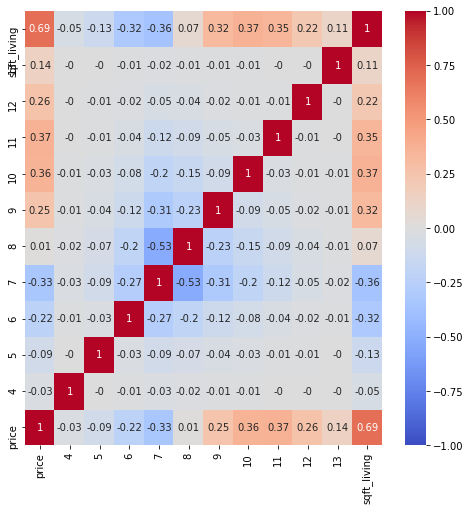

In [309]:
fig, ax = plt.subplots(figsize=(8,8))
#mask = np.triu(df_high_corr.corr())
ax = sns.heatmap(round(tot_grade.corr(),2)
                 ,annot=True
                 #,mask=mask
                 ,cmap='coolwarm'
                 ,vmin=-1)
ax.set_ylim((0,12))
tot_grade.shape

(1024, 10)

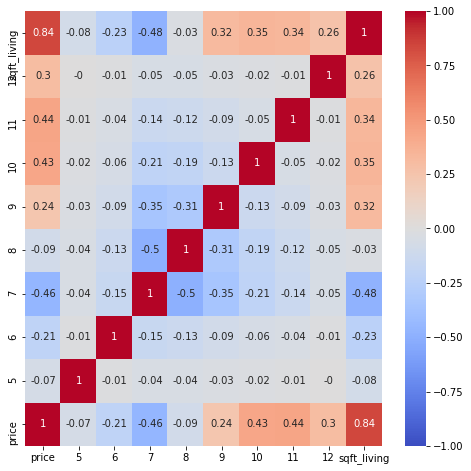

In [310]:
fig, ax = plt.subplots(figsize=(8,8))
#mask = np.triu(df_high_corr.corr())
ax = sns.heatmap(round(no_grade.corr(),2)
                 ,annot=True
                 #,mask=mask
                 ,cmap='coolwarm'
                 ,vmin=-1)
ax.set_ylim((0,10))
no_grade.shape

(5508, 12)

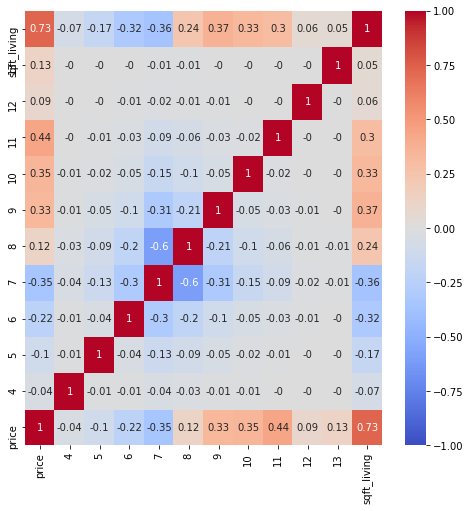

In [311]:
fig, ax = plt.subplots(figsize=(8,8))
#mask = np.triu(df_high_corr.corr())
ax = sns.heatmap(round(so_grade.corr(),2)
                 ,annot=True
                 #,mask=mask
                 ,cmap='coolwarm'
                 ,vmin=-1)
ax.set_ylim((0,12))
so_grade.shape

(6048, 11)

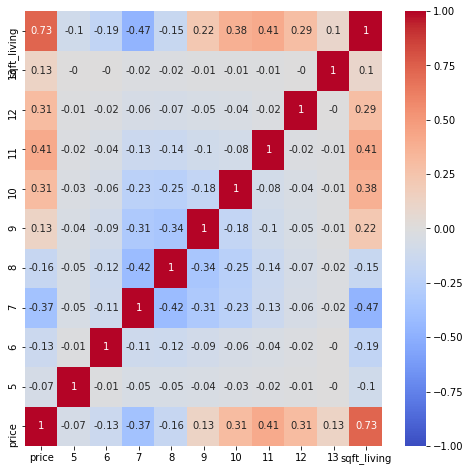

In [312]:
fig, ax = plt.subplots(figsize=(8,8))
#mask = np.triu(df_high_corr.corr())
ax = sns.heatmap(round(ea_grade.corr(),2)
                 ,annot=True
                 #,mask=mask
                 ,cmap='coolwarm'
                 ,vmin=-1)
ax.set_ylim((0,11))
ea_grade.shape

(8944, 21)

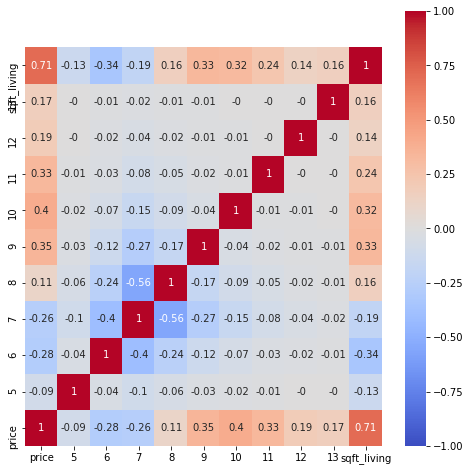

In [313]:
fig, ax = plt.subplots(figsize=(8,8))
#mask = np.triu(df_high_corr.corr())
ax = sns.heatmap(round(se_grade.corr(),2)
                 ,annot=True
                 #,mask=mask
                 ,cmap='coolwarm'
                 ,vmin=-1)
ax.set_ylim((0,12))
seattle_df.shape

### Add variables for grade to regression model

* Do not include all values, but only 7-12
* Tests showed that the model is not improved, when including more values for grade

In [314]:
# Complete Dataset
y = total_grade["price"]/1000000
ln_y = np.log(y)
#ln_X = np.log(X)
X1 = total_grade[["sqft_living"]]
X2 = total_grade[[7,8,9,10,11,12]]
ln_X1 = np.log(X1) 
X = pd.concat([ln_X1, X2], axis=1)
X_tot_grade_train, X_tot_grade_test, y_tot_grade_train, y_tot_grade_test = train_test_split(X, ln_y, test_size=0.2)
print("Train set length total (x,y)")
print(X_tot_grade_train.shape, y_tot_grade_train.shape)
print("Test set length total (x,y)")
print(X_tot_grade_test.shape, y_tot_grade_test.shape)

# North
y = north_grade["price"]/1000000
ln_y = np.log(y)
#ln_X = np.log(X)
X1 = north_grade[["sqft_living"]]
X2 = north_grade[[7,8,9,10,11,12]]
ln_X1 = np.log(X1) 
X = pd.concat([ln_X1, X2], axis=1)
X_north_grade_train, X_north_grade_test, y_north_grade_train, y_north_grade_test = train_test_split(X, ln_y, test_size=0.2)
print("Train set length North (x,y)")
print(X_north_grade_train.shape, y_north_grade_train.shape)
print("Test set length North (x,y)")
print(X_north_grade_test.shape, y_north_grade_test.shape)

# South
y = south_grade["price"]/1000000
ln_y = np.log(y)
#ln_X = np.log(X)
X1 = south_grade[["sqft_living"]]
X2 = south_grade[[7,8,9,10,11,12]]
ln_X1 = np.log(X1) 
X = pd.concat([ln_X1, X2], axis=1)
X_south_grade_train, X_south_grade_test, y_south_grade_train, y_south_grade_test = train_test_split(X, ln_y, test_size=0.2)
print("Train set length South (x,y)")
print(X_south_grade_train.shape, y_south_grade_train.shape)
print("Test set length South (x,y)")
print(X_south_grade_test.shape, y_south_grade_test.shape)

# East
y = east_grade["price"]/1000000
ln_y = np.log(y)
#ln_X = np.log(X)
X1 = east_grade[["sqft_living"]]
X2 = east_grade[[7,8,9,10,11,12]]
ln_X1 = np.log(X1) 
X = pd.concat([ln_X1, X2], axis=1)
X_east_grade_train, X_east_grade_test, y_east_grade_train, y_east_grade_test = train_test_split(X, ln_y, test_size=0.2)
print("Train set length East (x,y)")
print(X_east_grade_train.shape, y_east_grade_train.shape)
print("Test set length East (x,y)")
print(X_east_grade_test.shape, y_east_grade_test.shape)

# Seattle
y = seattle_grade["price"]/1000000
ln_y = np.log(y)
#ln_X = np.log(X)
X1 = seattle_grade[["sqft_living"]]
X2 = seattle_grade[[7,8,9,10,11,12]]
ln_X1 = np.log(X1) 
X = pd.concat([ln_X1, X2], axis=1)
X_seattle_grade_train, X_seattle_grade_test, y_seattle_grade_train, y_seattle_grade_test = train_test_split(X, ln_y, test_size=0.2)
print("Train set length Seattle (x,y)")
print(X_seattle_grade_train.shape, y_seattle_grade_train.shape)
print("Test set length Seattle (x,y)")
print(X_seattle_grade_test.shape, y_seattle_grade_test.shape)

Train set length total (x,y)
(17219, 7) (17219,)
Test set length total (x,y)
(4305, 7) (4305,)
Train set length North (x,y)
(819, 7) (819,)
Test set length North (x,y)
(205, 7) (205,)
Train set length South (x,y)
(4406, 7) (4406,)
Test set length South (x,y)
(1102, 7) (1102,)
Train set length East (x,y)
(4838, 7) (4838,)
Test set length East (x,y)
(1210, 7) (1210,)
Train set length Seattle (x,y)
(7155, 7) (7155,)
Test set length Seattle (x,y)
(1789, 7) (1789,)


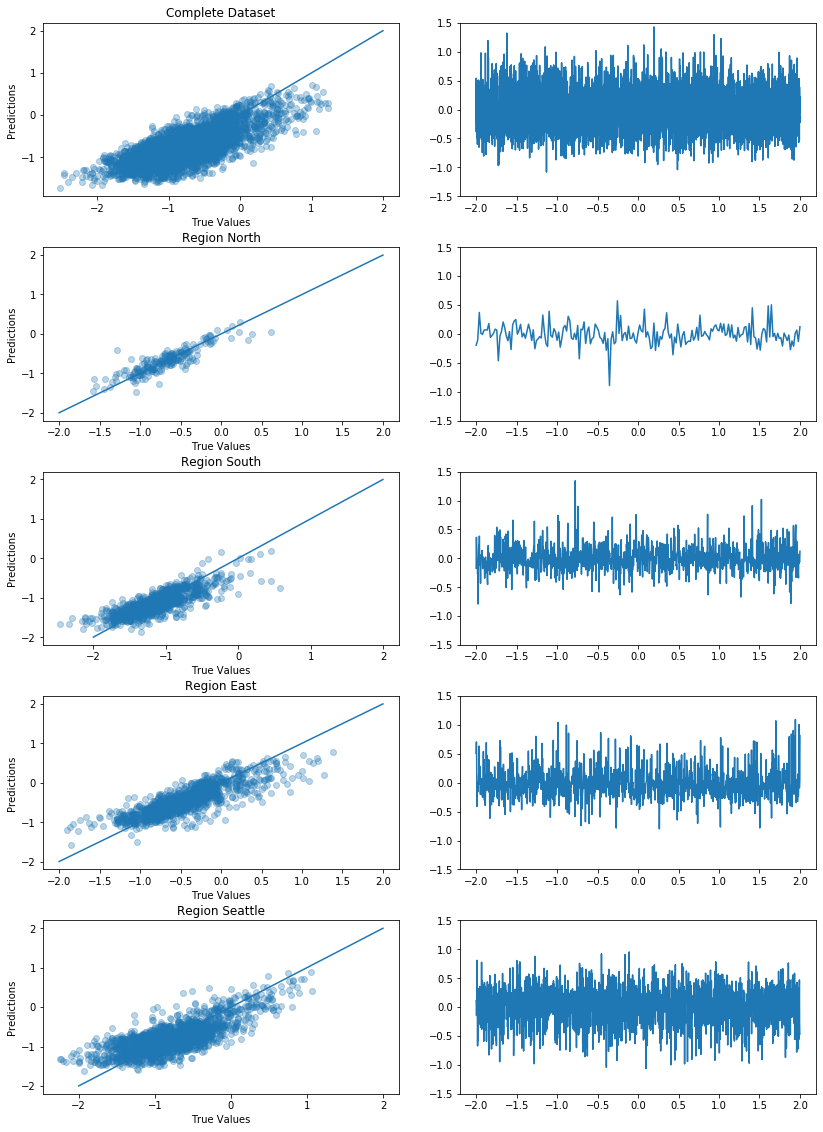

In [315]:
# fit a model
lm = linear_model.LinearRegression()
model_tot_grade = lm.fit(X_tot_grade_train, y_tot_grade_train)
predictions_tot_grade = lm.predict(X_tot_grade_test)

lm = linear_model.LinearRegression()
model_north_grade = lm.fit(X_north_grade_train, y_north_grade_train)
predictions_north_grade = lm.predict(X_north_grade_test)

lm = linear_model.LinearRegression()
model_south_grade = lm.fit(X_south_grade_train, y_south_grade_train)
predictions_south_grade = lm.predict(X_south_grade_test)

lm = linear_model.LinearRegression()
model_east_grade = lm.fit(X_east_grade_train, y_east_grade_train)
predictions_east_grade = lm.predict(X_east_grade_test)

lm = linear_model.LinearRegression()
model_seattle_grade = lm.fit(X_seattle_grade_train, y_seattle_grade_train)
predictions_seattle_grade = lm.predict(X_seattle_grade_test)

## The line / model
residuals_tot_grade = y_tot_grade_test - predictions_tot_grade
residuals_north_grade = y_north_grade_test - predictions_north_grade
residuals_south_grade = y_south_grade_test - predictions_south_grade
residuals_east_grade = y_east_grade_test - predictions_east_grade
residuals_seattle_grade = y_seattle_grade_test - predictions_seattle_grade

fig, ax = plt.subplots(5,2,figsize=(12,16))
fig.tight_layout(pad=3.0)
ax[0,0].scatter(y_tot_grade_test, predictions_tot_grade, alpha=0.3)
x = np.linspace(0,2,100)
y = np.linspace(0,2,100)
ax[0,0].plot(x,y)
ax[0,0].set_xlabel("True Values")
ax[0,0].set_ylabel("Predictions")
ax[0,0].set_title("Complete Dataset")

x1 = np.linspace(-2,2,4305)
ax[0,1].plot(x1,residuals_tot_grade)
ax[0,1].set_ylim(-1.5,1.5)

ax[1,0].scatter(y_north_grade_test, predictions_north_grade, alpha=0.3)
x = np.linspace(-2,2,100)
y = np.linspace(-2,2,100)
ax[1,0].plot(x,y)
ax[1,0].set_xlabel("True Values")
ax[1,0].set_ylabel("Predictions")
ax[1,0].set_title("Region North")

x1 = np.linspace(-2,2,205)
ax[1,1].plot(x1,residuals_north_grade)
ax[1,1].set_ylim(-1.5,1.5)

ax[2,0].scatter(y_south_grade_test, predictions_south_grade, alpha=0.3)
x = np.linspace(-2,2,100)
y = np.linspace(-2,2,100)
ax[2,0].plot(x,y)
ax[2,0].set_xlabel("True Values")
ax[2,0].set_ylabel("Predictions")
ax[2,0].set_title("Region South")

x1 = np.linspace(-2,2,1102)
ax[2,1].plot(x1,residuals_south_grade)
ax[2,1].set_ylim(-1.5,1.5)

ax[3,0].scatter(y_east_grade_test, predictions_east_grade, alpha=0.3)
x = np.linspace(-2,2,100)
y = np.linspace(-2,2,100)
ax[3,0].plot(x,y)
ax[3,0].set_xlabel("True Values")
ax[3,0].set_ylabel("Predictions")
ax[3,0].set_title("Region East")

x1 = np.linspace(-2,2,1210)
ax[3,1].plot(x1,residuals_east_grade)
ax[3,1].set_ylim(-1.5,1.5)

ax[4,0].scatter(y_seattle_grade_test, predictions_seattle_grade, alpha=0.3)
x = np.linspace(-2,2,100)
y = np.linspace(-2,2,100)
ax[4,0].plot(x,y)
ax[4,0].set_xlabel("True Values")
ax[4,0].set_ylabel("Predictions")
ax[4,0].set_title("Region Seattle")

x1 = np.linspace(-2,2,1789)
ax[4,1].plot(x1,residuals_seattle_grade)
ax[4,1].set_ylim(-1.5,1.5);

plt.savefig('multiple_linear_regression_eval.jpg', dpi=300)

look at the p-values for the test cases

In [316]:
#p-values
print("p-values for complete dataset:")
mod = sms.OLS(y_tot_grade_test,X_tot_grade_test)
fii = mod.fit()
p_values = fii.summary2().tables[1]['P>|t|']
print(p_values)

print("p-values for region North:")
mod = sms.OLS(y_north_grade_test,X_north_grade_test)
fii = mod.fit()
p_values = fii.summary2().tables[1]['P>|t|']
print(p_values);

print("p-values for region South:")
mod = sms.OLS(y_south_grade_test,X_south_grade_test)
fii = mod.fit()
p_values = fii.summary2().tables[1]['P>|t|']
print(p_values)

print("p-values for region East:")
mod = sms.OLS(y_east_grade_test,X_east_grade_test)
fii = mod.fit()
p_values = fii.summary2().tables[1]['P>|t|']
print(p_values)

print("p-values for region Seattle:")
mod = sms.OLS(y_seattle_grade_test,X_seattle_grade_test)
fii = mod.fit()
p_values = fii.summary2().tables[1]['P>|t|']
print(p_values);

p-values for complete dataset:
sqft_living     0.000000e+00
7               3.680020e-42
8              2.665529e-167
9              5.667549e-287
10              0.000000e+00
11             3.611862e-265
12              4.576521e-77
Name: P>|t|, dtype: float64
p-values for region North:
sqft_living    3.601919e-45
7              3.123955e-04
8              2.475917e-13
9              2.424702e-17
10             1.132290e-30
11             5.031833e-25
12             4.499337e-10
Name: P>|t|, dtype: float64
p-values for region South:
sqft_living    6.479383e-313
7               7.779534e-16
8               9.926657e-62
9               1.094829e-93
10              3.488988e-86
11              3.567421e-57
12                       NaN
Name: P>|t|, dtype: float64
p-values for region East:
sqft_living    3.494449e-68
7              8.572698e-02
8              1.522585e-13
9              1.331053e-36
10             2.187537e-57
11             6.238001e-73
12             4.572863e-56
Name: P

/Users/frauke/opt/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1827: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/frauke/opt/anaconda3/envs/nf/lib/python3.6/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/frauke/opt/anaconda3/envs/nf/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/frauke/opt/anaconda3/envs/nf/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/frauke/opt/anaconda3/envs/nf/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Observations:
 
* p-values are all smaller than 0.05, that is the coefficients are statistically significant at a 95% level

### How does the model perform?

In [317]:
print("R^2 complete Dataset")
print("{:.2}".format(r2_score(y_tot_grade_test, predictions_tot_grade, sample_weight=None, multioutput='uniform_average')))
print("R^2 North")
print("{:.2}".format(r2_score(y_north_grade_test, predictions_north_grade, sample_weight=None, multioutput='uniform_average')))
print("R^2 South")
print("{:.2}".format(r2_score(y_south_grade_test, predictions_south_grade, sample_weight=None, multioutput='uniform_average')))
print("R^2 East")
print("{:.2}".format(r2_score(y_east_grade_test, predictions_east_grade, sample_weight=None, multioutput='uniform_average')))
print("R^2 Seattle")
print("{:.2}".format(r2_score(y_seattle_grade_test, predictions_seattle_grade, sample_weight=None, multioutput='uniform_average')))

R^2 complete Dataset
0.55
R^2 North
0.78
R^2 South
0.65
R^2 East
0.69
R^2 Seattle
0.57


In [318]:
# calculate R^2 adjusted
# number of observations
n = X.shape[0]
# number of features
p = X.shape[1]
R_squ_tot = r2_score(y_tot_grade_test, predictions_tot_grade, sample_weight=None, multioutput='uniform_average')
R_squ_ad = 1 - (1 - R_squ_tot)*(n-1)/(n-p-1)
print("R^2 adjusted complete Dataset")
print("{:.2}".format(R_squ_ad))
R_squ_north = r2_score(y_north_grade_test, predictions_north_grade, sample_weight=None, multioutput='uniform_average')
R_squ_ad = 1 - (1 - R_squ_north)*(n-1)/(n-p-1)
print("R^2 adjusted North")
print("{:.2}".format(R_squ_ad))
R_squ_south = r2_score(y_south_grade_test, predictions_south_grade, sample_weight=None, multioutput='uniform_average')
R_squ_ad = 1 - (1 - R_squ_south)*(n-1)/(n-p-1)
print("R^2 adjusted South")
print("{:.2}".format(R_squ_ad))
R_squ_east = r2_score(y_east_grade_test, predictions_east_grade, sample_weight=None, multioutput='uniform_average')
R_squ_ad = 1 - (1 - R_squ_east)*(n-1)/(n-p-1)
print("R^2 adjusted East")
print("{:.2}".format(R_squ_ad))
R_squ_seattle = r2_score(y_seattle_grade_test, predictions_seattle_grade, sample_weight=None, multioutput='uniform_average')
R_squ_ad = 1 - (1 - R_squ_seattle)*(n-1)/(n-p-1)
print("R^2 adjusted Seattle")
print("{:.2}".format(R_squ_ad))

R^2 adjusted complete Dataset
0.55
R^2 adjusted North
0.78
R^2 adjusted South
0.65
R^2 adjusted East
0.69
R^2 adjusted Seattle
0.57


In [319]:
# mean squared error
print("MSE complete Dataset")
print("{:.2}".format(mean_squared_error(y_tot_grade_test, predictions_tot_grade)))
print("MSE North")
print("{:.2}".format(mean_squared_error(y_north_grade_test, predictions_north_grade)))
print("MSE South")
print("{:.2}".format(mean_squared_error(y_south_grade_test, predictions_south_grade)))
print("MSE East")
print("{:.2}".format(mean_squared_error(y_east_grade_test, predictions_east_grade)))
print("MSE Seattle")
print("{:.2}".format(mean_squared_error(y_seattle_grade_test, predictions_seattle_grade)))

MSE complete Dataset
0.12
MSE North
0.03
MSE South
0.051
MSE East
0.069
MSE Seattle
0.11


Observation:

* R² has improved for all models
* No difference between R² and R² adjusted
* The mean squared error has improved (is smaller) than in the simple linear regression for all models

### How do the coefficients look like?

In [320]:
print("Complete Dataset")
print("coefficient:")
print(model_tot_grade.coef_)
print("intercept: {:.2}".format(model_tot_grade.intercept_))
print("North")
print("coefficient:")
print(model_north_grade.coef_)
print("intercept: {:.2}".format(model_north_grade.intercept_))
print("South")
print("coefficient:")
print(model_south_grade.coef_)
print("intercept: {:.2}".format(model_south_ln.intercept_))
print("East")
print("coefficient:")
print(model_east_grade.coef_)
print("intercept: {:.2}".format(model_east_ln.intercept_))
print("Seattle")
print("coefficient:")
print(model_seattle_grade.coef_)
print("intercept: {:.2}".format(model_seattle_ln.intercept_))

Complete Dataset
coefficient:
[0.4502994  0.14906568 0.32722778 0.55270833 0.77028671 0.9754595
 1.21574904]
intercept: -4.5
North
coefficient:
[0.49131802 0.14002548 0.23909052 0.37355148 0.55038249 0.70862087
 0.87940365]
intercept: -4.7
South
coefficient:
[0.51305058 0.02829082 0.13461906 0.31733748 0.46773785 0.83294794
 0.84716232]
intercept: -6.8
East
coefficient:
[0.58657243 0.0368113  0.14422879 0.27078163 0.40206383 0.61474546
 0.7490258 ]
intercept: -7.4
Seattle
coefficient:
[0.47685156 0.18917388 0.38345779 0.67939807 0.95030896 1.16115946
 1.32374614]
intercept: -6.7


# Visualisation

### Simple linear regression (only depending on sqft_living)

* Compare the model resulting from the complete dataset with the models resulting from each region
* Use the model resulting from the complete dataset to predict the house prices for each of the region 

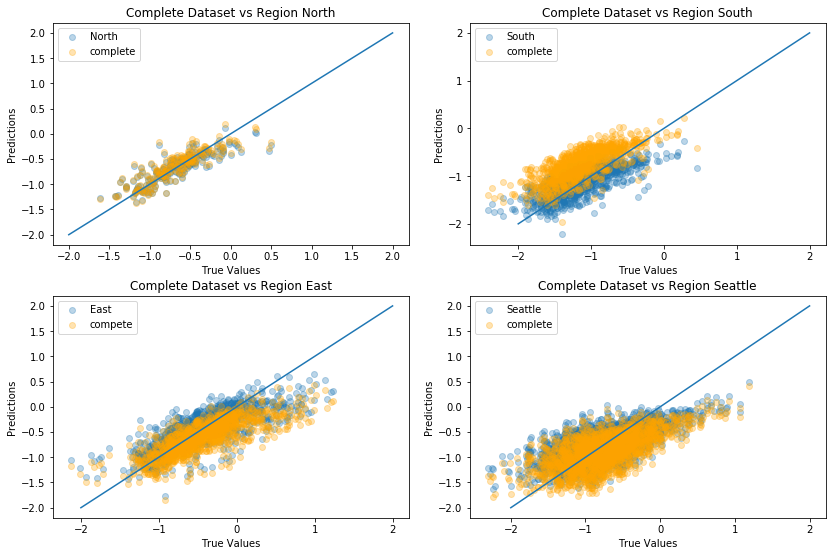

In [321]:
# plot prediction of each region vs the model using the entire dataset


# coefficients and intercepts for the different regions:
# complete dataset
lr_tot_co = model_tot_ln.coef_[0]
lr_tot_int = model_tot_ln.intercept_
# North
lr_north_co = model_north_ln.coef_[0]
lr_north_int = model_north_ln.intercept_
# South
lr_south_co = model_south_ln.coef_[0]
lr_south_int = model_south_ln.intercept_
# East
lr_east_co = model_east_ln.coef_[0]
lr_east_int = model_east_ln.intercept_
# Seattle
lr_seattle_co = model_seattle_ln.coef_[0]
lr_seattle_int = model_seattle_ln.intercept_

# plot for complete dataset: y_test, predictions from simple linear regression, predictions from simple linear regression using the other region for testing

predictions_tot_north = lr_tot_co*X_north_ln_test + lr_tot_int
predictions_tot_south = lr_tot_co*X_south_ln_test + lr_tot_int
predictions_tot_east = lr_tot_co*X_east_ln_test + lr_tot_int
predictions_tot_seattle = lr_tot_co*X_seattle_ln_test + lr_tot_int

color=["#1f77b4","orange"]

fig, ax = plt.subplots(2,2,figsize=(12,8))
fig.tight_layout(pad=3.0)
ax[0,0].scatter(y_north_ln_test, predictions_north_ln, alpha = 0.3, label="North", c=color[0])
ax[0,0].scatter(y_north_ln_test, predictions_tot_north, alpha = 0.3, label="complete", c=color[1])
x = np.linspace(-2,2,100)
y = np.linspace(-2,2,100)
ax[0,0].plot(x, y, c=color[0])
ax[0,0].legend()
ax[0,0].set_xlabel("True Values")
ax[0,0].set_ylabel("Predictions")
ax[0,0].set_title("Complete Dataset vs Region North")

ax[0,1].scatter(y_south_ln_test, predictions_south_ln, alpha = 0.3, label="South", c=color[0])
ax[0,1].scatter(y_south_ln_test, predictions_tot_south, alpha = 0.3, label="complete", c=color[1])
x = np.linspace(-2,2,100)
y = np.linspace(-2,2,100)
ax[0,1].plot(x, y, c=color[0])
ax[0,1].legend()
ax[0,1].set_xlabel("True Values")
ax[0,1].set_ylabel("Predictions")
ax[0,1].set_title("Complete Dataset vs Region South")

ax[1,0].scatter(y_east_ln_test, predictions_east_ln, alpha = 0.3, label="East", c=color[0])
ax[1,0].scatter(y_east_ln_test, predictions_tot_east, alpha = 0.3, label="compete", c=color[1])
x = np.linspace(-2,2,100)
y = np.linspace(-2,2,100)
ax[1,0].plot(x, y ,c=color[0])
ax[1,0].legend()
ax[1,0].set_xlabel("True Values")
ax[1,0].set_ylabel("Predictions")
ax[1,0].set_title("Complete Dataset vs Region East")

ax[1,1].scatter(y_seattle_ln_test, predictions_seattle_ln, alpha = 0.3, label="Seattle", c=color[0])
ax[1,1].scatter(y_seattle_ln_test, predictions_tot_seattle, alpha = 0.3, label="complete", c=color[1])
x = np.linspace(-2,2,100)
y = np.linspace(-2,2,100)
ax[1,1].plot(x, y, c=color[0])
ax[1,1].legend()
ax[1,1].set_xlabel("True Values")
ax[1,1].set_ylabel("Predictions")
ax[1,1].set_title("Complete Dataset vs Region Seattle");

plt.savefig('simple_linear_regression_eval_regModels.jpg', dpi=300)

### Multiple linear regression (sqft_living, grade)

* Compare the model resulting from the complete dataset with the models resulting from each region
* Use the model resulting from the complete dataset to predict the house prices for each of the region 

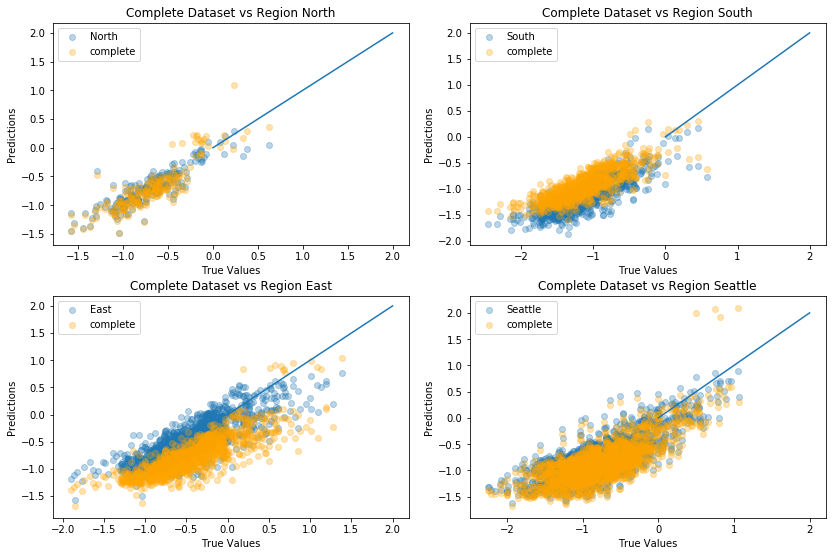

In [322]:
# plot prediction of each region vs the model using the entire dataset

# coefficients and intercepts for the different regions:
# complete dataset
lr_tot_co = model_tot_grade.coef_
lr_tot_int = model_tot_grade.intercept_
# North
lr_north_co = model_north_grade.coef_
lr_north_int = model_north_grade.intercept_
# South
lr_south_co = model_south_grade.coef_
lr_south_int = model_south_grade.intercept_
# East
lr_east_co = model_east_grade.coef_
lr_east_int = model_east_grade.intercept_
# Seattle
lr_seattle_co = model_seattle_grade.coef_
lr_seattle_int = model_seattle_grade.intercept_


# plot for complete dataset: y_test, predictions from simple linear regression, predictions from simple linear regression using the other region for testing

predictions_tot_north_mr = lr_tot_co[0]*X_north_grade_test.iloc[:,0]+lr_north_co[1]*X_north_grade_test.iloc[:,1]+lr_north_co[2]*X_north_grade_test.iloc[:,2]+lr_north_co[3]*X_north_grade_test.iloc[:,3]+lr_seattle_co[4]*X_north_grade_test.iloc[:,4]+lr_north_co[5]*X_north_grade_test.iloc[:,5]+lr_north_co[6]*X_north_grade_test.iloc[:,6]+lr_north_co[6]*X_north_grade_test.iloc[:,6]+lr_tot_int
predictions_tot_south_mr = lr_tot_co[0]*X_south_grade_test.iloc[:,0]+lr_south_co[1]*X_south_grade_test.iloc[:,1]+lr_south_co[2]*X_south_grade_test.iloc[:,2]+lr_south_co[3]*X_south_grade_test.iloc[:,3]+lr_south_co[4]*X_south_grade_test.iloc[:,4]+lr_south_co[5]*X_south_grade_test.iloc[:,5]+lr_south_co[6]*X_south_grade_test.iloc[:,6]+lr_south_co[6]*X_south_grade_test.iloc[:,6]+lr_tot_int
predictions_tot_east_mr = lr_tot_co[0]*X_east_grade_test.iloc[:,0]+lr_east_co[1]*X_east_grade_test.iloc[:,1]+lr_east_co[2]*X_east_grade_test.iloc[:,2]+lr_east_co[3]*X_east_grade_test.iloc[:,3]+lr_east_co[4]*X_east_grade_test.iloc[:,4]+lr_east_co[5]*X_east_grade_test.iloc[:,5]+lr_east_co[6]*X_east_grade_test.iloc[:,6]+lr_east_co[6]*X_east_grade_test.iloc[:,6]+ lr_tot_int
predictions_tot_seattle_mr = lr_tot_co[0]*X_seattle_grade_test.iloc[:,0]+lr_seattle_co[1]*X_seattle_grade_test.iloc[:,1]+lr_seattle_co[2]*X_seattle_grade_test.iloc[:,2]+lr_seattle_co[3]*X_seattle_grade_test.iloc[:,3]+lr_seattle_co[4]*X_seattle_grade_test.iloc[:,4]+lr_seattle_co[5]*X_seattle_grade_test.iloc[:,5]+lr_seattle_co[6]*X_seattle_grade_test.iloc[:,6]+lr_seattle_co[6]*X_seattle_grade_test.iloc[:,6]+lr_tot_int
predictions_tot_tot_mr = lr_tot_co[0]*X_tot_grade_test.iloc[:,0]+lr_tot_co[1]*X_tot_grade_test.iloc[:,1]+lr_tot_co[2]*X_tot_grade_test.iloc[:,2]+lr_tot_co[3]*X_tot_grade_test.iloc[:,3]+lr_tot_co[4]*X_tot_grade_test.iloc[:,4]+lr_tot_co[5]*X_tot_grade_test.iloc[:,5]+lr_tot_co[6]*X_tot_grade_test.iloc[:,6]+lr_tot_co[6]*X_tot_grade_test.iloc[:,6]+lr_tot_int

color=["#1f77b4","orange"]

fig, ax = plt.subplots(2,2,figsize=(12,8))
fig.tight_layout(pad=3.0)
ax[0,0].scatter(y_north_grade_test, predictions_north_grade, alpha = 0.3, label="North", c=color[0])
ax[0,0].scatter(y_north_grade_test, predictions_tot_north_mr, alpha = 0.3, label="complete", c=color[1])
x = np.linspace(0,2,100)
y = np.linspace(0,2,100)
ax[0,0].plot(x,y)
ax[0,0].legend()
ax[0,0].set_xlabel("True Values")
ax[0,0].set_ylabel("Predictions")
ax[0,0].set_title("Complete Dataset vs Region North")
#ax[0,0].scatter(y_tot_grade_test, predictions_tot_grade, alpha=0.3, c="green")
#ax[0,0].scatter(y_tot_grade_test, predictions_tot_tot_mr, alpha=0.3, c="red")

ax[0,1].scatter(y_south_grade_test, predictions_south_grade, alpha = 0.3, label="South", c=color[0])
ax[0,1].scatter(y_south_grade_test, predictions_tot_south_mr, alpha = 0.3, label="complete", c=color[1])
x = np.linspace(0,2,100)
y = np.linspace(0,2,100)
ax[0,1].plot(x,y)
ax[0,1].legend()
ax[0,1].set_xlabel("True Values")
ax[0,1].set_ylabel("Predictions")
ax[0,1].set_title("Complete Dataset vs Region South")
#ax[0,1].scatter(y_tot_grade_test, predictions_tot_grade, alpha=0.3, c="green")

ax[1,0].scatter(y_east_grade_test, predictions_east_grade, alpha = 0.3, label="East", c=color[0])
ax[1,0].scatter(y_east_grade_test, predictions_tot_east_mr, alpha = 0.3, label="complete", c=color[1])
x = np.linspace(0,2,100)
y = np.linspace(0,2,100)
ax[1,0].plot(x,y)
ax[1,0].legend()
ax[1,0].set_xlabel("True Values")
ax[1,0].set_ylabel("Predictions")
ax[1,0].set_title("Complete Dataset vs Region East")
#ax[1,0].scatter(y_tot_grade_test, predictions_tot_grade, alpha=0.3, c="green")

ax[1,1].scatter(y_seattle_grade_test, predictions_seattle_grade, alpha = 0.3, label="Seattle", c=color[0])
ax[1,1].scatter(y_seattle_grade_test, predictions_tot_seattle_mr, alpha = 0.3, label="complete", c=color[1])
x = np.linspace(0,2,100)
y = np.linspace(0,2,100)
ax[1,1].plot(x,y)
ax[1,1].legend()
ax[1,1].set_xlabel("True Values")
ax[1,1].set_ylabel("Predictions")
ax[1,1].set_title("Complete Dataset vs Region Seattle")
#ax[1,1].scatter(y_tot_grade_test, predictions_tot_grade, alpha=0.3, c="green")

plt.savefig('multiple_linear_regression_eval_regModels.jpg', dpi=300)

# Conclusions

* The features used in the models for the different regions are the same
* Coefficients differ depending on the region
* Multiple linear regression including "grade" improves the model for all regions (measured in R² and mse)
* The simple linear regression (with logarithmic transformation) shows already quite good performance (especially for the region North)
* Considering the simple linear regression (with feature sqft_living), no big difference can be observed compared to the performance of the model based on the complete dataset
* Considering the multiple linear regression (with feature sqft_living and grade), the performance of the model adjusted for each region seems to be better for the South and the East
* Note: Keep in mind the different sizes of the dataset for each region! Most data is from Seattle

# Outlook

* Repeat the analysis with datasets of the same size
* Analyse other features to improve the model
* Analyse possible non-linear dependencies
* Include more features not available from the dataset, which are important for each region (e.g. shopping centers nearby, climate,...)
* Review the regions, are there better criterias for the division 
* Analyse the city of Seattle in more detail. Maybe the model is depending on the district and coefficients and/or features should be adjusted for different districts
